# Model Training

## Questions
Is this a classification or regression task?  

This is a classification task.

Are you predicting for multiple classes or binary classes?  

we are predicting for binary classes - Fraud (1) / not Fraud (0)

Given these observations, which 2 (or possibly 3) machine learning models will you choose?  

Logistic regression, Random forest , XG boost etc

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/transformed_data.csv')
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount_log10,oldbalanceOrg_log10,newbalanceOrig_log10,oldbalanceDest_log10,newbalanceDest_log10,amount_transfer,amount_transfer_log10
0,983.09,36730.24,35747.15,0.00,0.00,0,0.0,0.0,0.0,1.0,0.0,2.992593,4.565024,4.553241,0.000000,0.000000,0.00,0.000000
1,55215.25,99414.00,44198.75,0.00,0.00,0,0.0,0.0,0.0,1.0,0.0,4.742059,4.997448,4.645410,0.000000,0.000000,0.00,0.000000
2,220986.01,7773074.97,7994060.98,924031.48,703045.48,0,1.0,0.0,0.0,0.0,0.0,5.344365,6.890593,6.902767,5.965687,5.846983,0.00,0.000000
3,2357394.75,0.00,0.00,4202580.45,6559975.19,0,0.0,0.0,0.0,0.0,1.0,6.372432,0.000000,0.000000,6.623516,6.816902,2357394.75,6.372432
4,67990.14,0.00,0.00,625317.04,693307.19,0,0.0,1.0,0.0,0.0,0.0,4.832446,0.000000,0.000000,5.796100,5.840926,0.00,0.000000


### First Model - Logistic Regression

### 1) Create a train-test split

In [3]:
from sklearn.model_selection import train_test_split


X = data.drop(['isFraud'],axis=1)
y = data['isFraud']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)



In [5]:
!pip install imblearn

In [ ]:
# Apply SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [7]:
from sklearn.preprocessing import StandardScaler
 #Standardize features/ scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)


In [8]:
print("Original X_train shape:", X_train.shape)
print("After SMOTE X_train shape:", X_train_smote.shape)
print("X_test shape:", X_test.shape)

Original X_train shape: (800000, 17)
After SMOTE X_train shape: (1597924, 17)
X_test shape: (200000, 17)


In [11]:
from sklearn.linear_model import LogisticRegression

#instatiate model
log_model = LogisticRegression(class_weight='balanced')

#fit model
log_model.fit(X_train_scaled,y_train_smote)


/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [12]:
# predict
y_pred = log_model.predict(X_test_scaled)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(200000,))

In [13]:
# to find metric

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score ,recall_score, precision_score, f1_score, classification_report

Confusion_matrix = confusion_matrix(y_test,y_pred)
Confusion_matrix

array([[194381,   5360],
       [     1,    258]])

In [14]:
Accuracy = accuracy_score( y_test,y_pred) 
Accuracy


0.973195

In [15]:
# Generate classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    199741
           1       0.05      1.00      0.09       259

    accuracy                           0.97    200000
   macro avg       0.52      0.98      0.54    200000
weighted avg       1.00      0.97      0.99    200000



 Recall = .97 and f1-score = .99 but precision for 1(fraud) is 5%. ie,model is making a lot of false positives.
 
          

### 2) Search for best hyperparameters

### GridSearch

In [16]:

from sklearn.model_selection import GridSearchCV

# Define hyperparameters to search
param_grid = {
    'C': [0.01, 0.1, 1, 10], 
    'penalty': ['l2'], 
    'solver': ['saga'], 
    'max_iter': [100]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_smote)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn

Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.9805596318437599


/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### RandomSearch

In [17]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'C': np.logspace(-3, 2, 10),
    'penalty': ['l2'],
    'solver': ['saga'],
    'max_iter': [100, 200, 500]
}

random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=param_dist,
                                   n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train_smote)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn

Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 500, 'C': np.float64(7.742636826811277)}
Best Score: 0.9817639531428585


/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 3) Train your model
Select the model with best hyperparameters and generate predictions on your test set. Evaluate your models accuracy, precision, recall, and sensitivity.  

Use the RandomizedSearchCV parameters because they give slightly better accuracy.

In [18]:
log_model = LogisticRegression(
    C=7.74,
    max_iter=500,
    penalty='l2',
    solver='saga',
    random_state=42     
)
log_model.fit(X_train_scaled, y_train_smote)


/opt/miniconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=7.74, max_iter=500, random_state=42, solver='saga')

In [19]:

# Predict on test data
y_pred = log_model.predict(X_test_scaled)

Accuracy: 0.968935
Precision: 0.040018541409147096
Recall: 1.0
F1 Score: 0.07695736146189273

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.98    199741
       Fraud       0.04      1.00      0.08       259

    accuracy                           0.97    200000
   macro avg       0.52      0.98      0.53    200000
weighted avg       1.00      0.97      0.98    200000



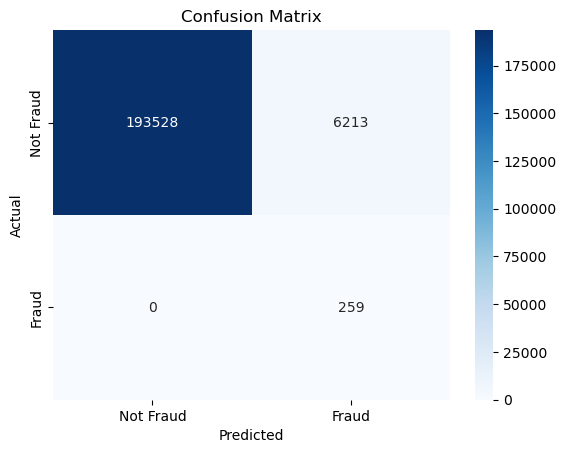

In [20]:

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Detailed Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


After hyperparameter tuning, the model’s precision dropped to around 4%, indicating that a large number of non-fraudulent transactions were incorrectly predicted as fraud. 

##  Second Model - Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier


# 1. Initialize and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_smote)



RandomForestClassifier(random_state=42)

In [23]:
# 2. Predict on test set (make sure test set is also scaled)
y_pred = rf.predict(X_test_scaled)


In [24]:
# 3. Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[199599    142]
 [    26    233]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199741
           1       0.62      0.90      0.74       259

    accuracy                           1.00    200000
   macro avg       0.81      0.95      0.87    200000
weighted avg       1.00      1.00      1.00    200000



When using Random Forest, the model's precision increased to 62%, ie, it significantly reduced false positives,it became better at correctly identifying non-fraud cases. However, this also led to an increase in true negatives and false negatives, some actual fraud cases were missed. 

### Third Model - XGBoost



In [26]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00


In [27]:
import xgboost as xgb

# 1. Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


In [29]:
# 2. Train the model
xgb_model.fit(X_train_scaled, y_train_smote)


/opt/miniconda3/envs/ds/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:23:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [30]:
# 3. Make predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)

# 4. Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[198830    911]
 [     5    254]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199741
           1       0.22      0.98      0.36       259

    accuracy                           1.00    200000
   macro avg       0.61      0.99      0.68    200000
weighted avg       1.00      1.00      1.00    200000



The XGBoost model achieved very high recall (0.98) but low precision (0.22), it caught almost all fraud cases but also flagged many non-fraud transactions incorrectly.

In [33]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [ ]:
# Define the Parameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [34]:
#initialize the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [ ]:
# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1', 
    cv=3,
    verbose=1,
    n_jobs=-1
)


In [36]:
grid_search.fit(X_train_scaled, y_train_smote)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/opt/miniconda3/envs/ds/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/ds/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:12:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not use

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

In [37]:
# get best parameter
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [38]:
# Predict on test set
y_pred = best_model.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[199512    229]
 [    12    247]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199741
           1       0.52      0.95      0.67       259

    accuracy                           1.00    200000
   macro avg       0.76      0.98      0.84    200000
weighted avg       1.00      1.00      1.00    200000



## Conclusion:
 I chose XGBoost because it achieved a high recall of 95%, it successfully identified most fraudulent transactions. While its precision (52%) is slightly lower than Random Forest, XGBoost produced fewer false negatives, making it more effective for fraud detection where catching all fraud cases is a priority.